In [1]:
import utils
import metrics
import CNNLSTMModel
import ConvLSTM2DModel

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

LUCKY_NUMBER = 2
TARGET_SIZE = (128, 128) # For no compression choose -1
TARGET_SLICES = 100

PHOTOS_PATH = "/media/kaczmarski/DataStorage/images/"
MASK_PATH = "/media/kaczmarski/DataStorage/masks/"

2024-12-10 22:05:18.720594: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 22:05:18.721333: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 22:05:18.723908: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 22:05:18.730547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733864718.741703  816987 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733864718.74

In [ ]:
print("GPUs Available: ",tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Prepare data

In [2]:
np.random.seed(LUCKY_NUMBER)
batch_size = 1
epochs = 40

scan_names = [file[:8] for file in os.listdir(PHOTOS_PATH) if file.endswith(".nii.gz")]
train, val, test = utils.split_train_val_test(scan_names, 0.7, 0.15, 0.15)
print(f"Training data size: {len(train)}, Validation data size: {len(val)}, Test data size: {len(test)}")

print(train)
train_gen = utils.cbct_data_generator(PHOTOS_PATH, MASK_PATH, train)
val_gen = utils.cbct_data_generator(PHOTOS_PATH, MASK_PATH, val)


#model = CNNLSTMModel.create_cnn_lstm_model(image_shape=TARGET_SIZE, num_slices=50)
model = ConvLSTM2DModel.create_cnn_convlstm2d_model(image_shape=TARGET_SIZE, num_slices=TARGET_SLICES)
model.summary()

print(model.output_shape)

Training data size: 98, Validation data size: 21, Test data size: 21
['ZEBY_183', 'ZEBY_218', 'ZEBY_107', 'ZEBY_202', 'ZEBY_209', 'ZEBY_130', 'ZEBY_160', 'ZEBY_122', 'ZEBY_117', 'ZEBY_194', 'ZEBY_128', 'ZEBY_136', 'ZEBY_182', 'ZEBY_178', 'ZEBY_232', 'ZEBY_224', 'ZEBY_200', 'ZEBY_201', 'ZEBY_185', 'ZEBY_124', 'ZEBY_179', 'ZEBY_227', 'ZEBY_119', 'ZEBY_162', 'ZEBY_175', 'ZEBY_102', 'ZEBY_157', 'ZEBY_120', 'ZEBY_206', 'ZEBY_110', 'ZEBY_161', 'ZEBY_135', 'ZEBY_141', 'ZEBY_111', 'ZEBY_199', 'ZEBY_187', 'ZEBY_127', 'ZEBY_133', 'ZEBY_237', 'ZEBY_163', 'ZEBY_158', 'ZEBY_174', 'ZEBY_238', 'ZEBY_118', 'ZEBY_190', 'ZEBY_240', 'ZEBY_198', 'ZEBY_109', 'ZEBY_214', 'ZEBY_223', 'ZEBY_150', 'ZEBY_180', 'ZEBY_230', 'ZEBY_228', 'ZEBY_220', 'ZEBY_151', 'ZEBY_177', 'ZEBY_153', 'ZEBY_181', 'ZEBY_167', 'ZEBY_229', 'ZEBY_184', 'ZEBY_233', 'ZEBY_171', 'ZEBY_147', 'ZEBY_169', 'ZEBY_189', 'ZEBY_170', 'ZEBY_222', 'ZEBY_159', 'ZEBY_134', 'ZEBY_207', 'ZEBY_139', 'ZEBY_204', 'ZEBY_152', 'ZEBY_208', 'ZEBY_143', 'ZEBY_

W0000 00:00:1733864723.494854  816987 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/kaczmarski/Desktop/teeth-segmentation-cbct-images-cnn-lstm/thesis-env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 100, 128, 128,  │         9,856 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 100, 64, 64,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 64, 64,    │             0 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 100, 64, 64,    │        55,424 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 100, 32, 32,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 100, 32, 32,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 100, 32, 32,    │       221,440 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 100, 16, 16,    │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 100, 16, 16,    │             0 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 100, 32, 32,    │        36,928 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 100, 64, 64,    │        18,464 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 100, 128, 128,  │         4,624 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 100, 128, 128,  │            17 │
│ (TimeDistributed)               │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,753 (1.32 MB)

 Trainable params: 346,753 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

(None, 100, 128, 128, 1)


Train model

In [ ]:
model.layers[9].input.shape

In [ ]:
model.fit(
    train_gen, 
    batch_size=1,
    steps_per_epoch=len(train)//batch_size,
    validation_data=val_gen,
    validation_steps=len(val)//batch_size,
    epochs=epochs)

In [4]:
utils.save_model(model)

Saving model...
Model saved to models/CNN-LSTM-teeth-segmentation-model-12-11-2024-02-59.keras
Saving history...
History saved to models/history-12-11-2024-02-59.json


Make prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[False False False ... False False False]
 [False False  True ...  True  True False]
 [False False  True ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False  True ...  True  True  True]
 [False False False ...  True  True False]]


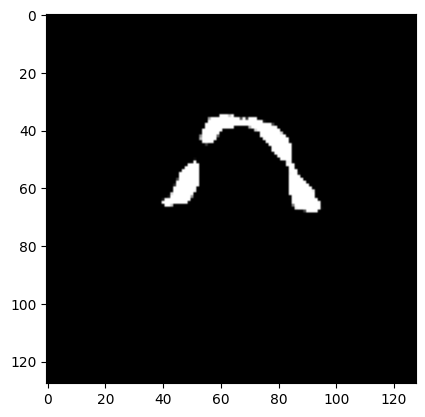

In [6]:
test_scan = utils.load_nifti_cbct_scan(PHOTOS_PATH+test[15]+"_0000.nii.gz")
test_scan = test_scan[..., np.newaxis]
test_scan = np.expand_dims(test_scan, axis=0)

predictions = model.predict(test_scan)

predicted_mask = predictions[0]

binary_mask = (predicted_mask > 0.5).astype(np.float32)

print(predicted_mask[25,:,:,0] == predicted_mask[30,:,:,0])

plt.imshow(predicted_mask[25, :, :, 0], cmap="gray")

Plot results

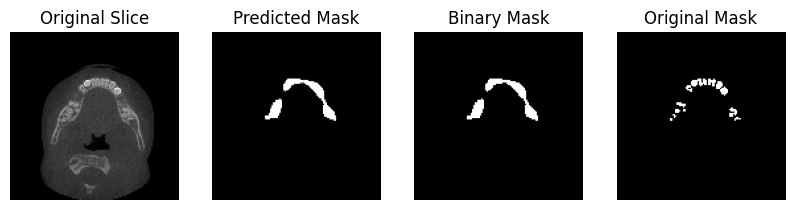

In [7]:
slice_index = 20

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.title("Original Slice")
plt.imshow(test_scan[0, slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Binary Mask")
plt.imshow(binary_mask[slice_index, :, :, 0], cmap="gray")
plt.axis('off')

original_mask = utils.load_nifti_mask(MASK_PATH+test[15]+".nii.gz")
plt.subplot(1, 4, 4)
plt.title("Original Mask")
plt.imshow(original_mask[slice_index,:,:], cmap="gray")
plt.axis('off')
plt.show()